# k-Nearest Neighbor (kNN) implementation

*Credits: this notebook is deeply based on Stanford CS231n course assignment 1. Source link: http://cs231n.github.io/assignments2019/assignment1/*

Классификатор kNN состоит из двух этапов:

- Во время обучения классификатор принимает обучающие данные и просто запоминает их.
- Во время тестирования kNN классифицирует каждое тестовое изображение, сравнивая его со всеми обучающими изображениями и передавая метки k наиболее похожих обучающих примеров.
- Значение k определяется с помощью кросс-валидации.

В этом упражнении вы реализуете эти шаги, чтобы понять базовый процесс классификации изображений и приобрести навыки написания эффективного векторизованного кода.

Мы будем работать с набором данных рукописных цифр. Изображения будут "развёрнуты" (изображение размером 8x8 -> вектор размером 64) и обработаны как векторы.

In [ ]:
'''
If you are using Google Colab, uncomment the next line to download `k_nearest_neighbor.py`. 
You can open and change it in Colab using the "Files" sidebar on the left.
'''
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/assignment0_01_knn/k_nearest_neighbor.py

In [1]:
from sklearn import datasets
dataset = datasets.load_digits()
print(dataset.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

In [2]:
# Первые 100 изображений будут использованы для тестирования. Этот набор данных не отсортирован по меткам,  
# поэтому такой способ разделения данных вполне подходит.  
# Пожалуйста, будьте осторожны при разделении данных на обучающие и тестовые в целом.  
test_border = 100
X_train, y_train = dataset.data[test_border:], dataset.target[test_border:]
X_test, y_test = dataset.data[:test_border], dataset.target[:test_border]

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
num_test = X_test.shape[0]

Training data shape:  (1697, 64)
Training labels shape:  (1697,)
Test data shape:  (100, 64)
Test labels shape:  (100,)


In [5]:
# Run some setup code for this notebook.
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


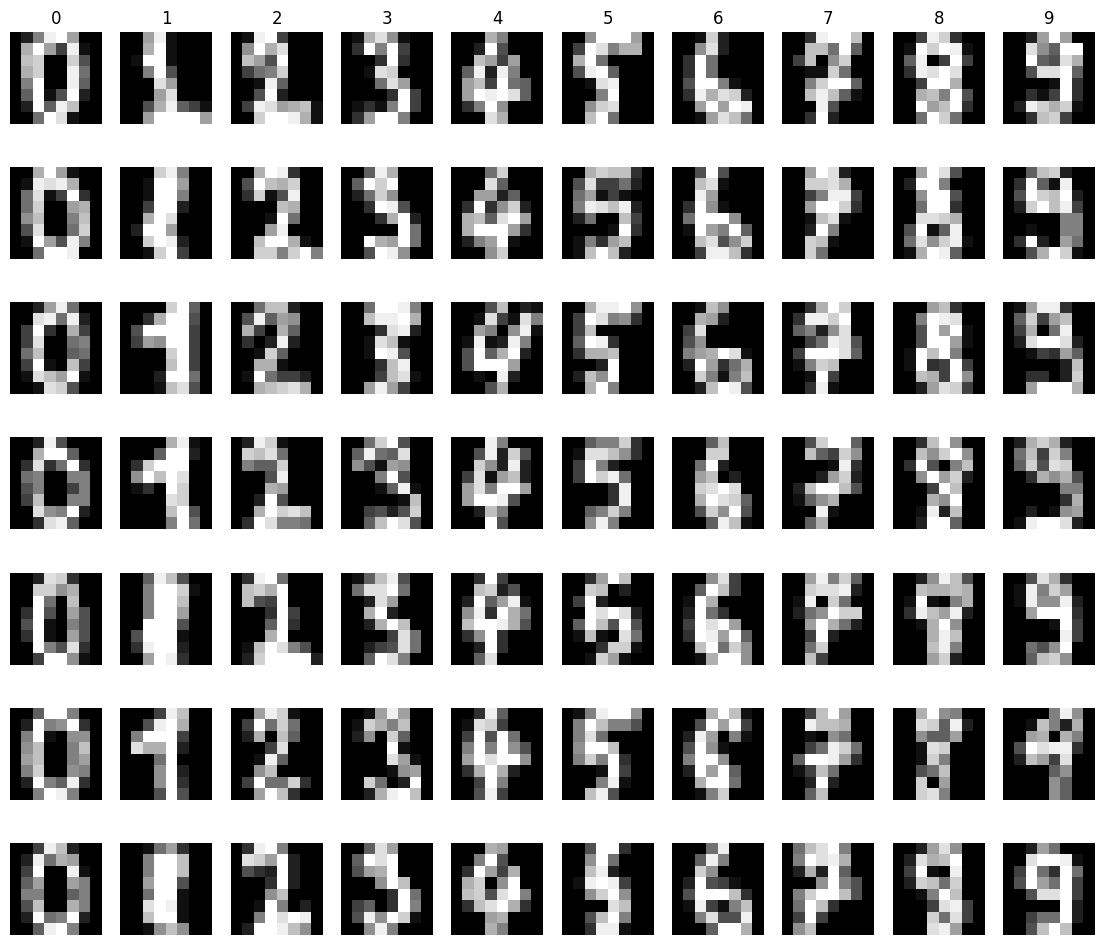

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((8, 8)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Автоматическая перезагрузка — это отличная штука, но иногда она не работает так, как должно. Код ниже направлен на решение этой проблемы.  
__Не забудьте сохранить изменения в файле `.py` перед перезагрузкой класса `KNearestNeighbor`.__  

In [9]:
# This dirty hack might help if the autoreload has failed for some reason
try:
    del KNearestNeighbor
except:
    pass

from k_nearest_neighbor import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.fit(X_train, y_train)

In [10]:
X_train.shape

(1697, 64)

Теперь мы хотим классифицировать тестовые данные с помощью классификатора kNN. Напоминаем, что этот процесс можно разделить на два этапа:

1. Сначала мы должны вычислить расстояния между всеми тестовыми примерами и всеми обучающими примерами.
2. Имея эти расстояния, для каждого тестового примера мы находим k ближайших примеров и заставляем их голосовать за метку.

Давайте начнем с вычисления матрицы расстояний между всеми обучающими и тестовыми примерами. Например, если есть **Ntr** обучающих примеров и **Nte** тестовых примеров, на этом этапе должна быть получена матрица размером **Nte x Ntr**, где каждый элемент (i, j) — это расстояние между i-м тестовым примером и j-м обучающим примером.

**Примечание:** Для трех вычислений расстояний, которые вам нужно реализовать в этом ноутбуке, нельзя использовать функцию np.linalg.norm(), предоставляемую numpy.

Сначала откройте `k_nearest_neighbor.py` и реализуйте функцию `compute_distances_two_loops`, которая использует (очень неэффективный) двойной цикл по всем парам (тест, обучающий) и вычисляет матрицу расстояний по одному элементу за раз.

In [11]:
# Open k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(100, 1697)


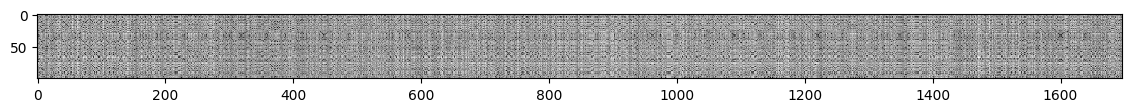

In [12]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Вопрос 1**  

Обратите внимание на структурированные паттерны в матрице расстояний, где некоторые строки или столбцы видны ярче. (Обратите внимание, что в стандартной цветовой схеме черный цвет указывает на низкие расстояния, а белый — на высокие расстояния.)

- Что в данных вызывает явно яркие строки?
- Что вызывает яркие столбцы?

$\color{blue}{\textit Ваш ответ:}$ 

#### 1. Что вызывает явно яркие строки?

Яркие строки (с белыми участками) появляются там, где тестовая точка далеко от большинства обучающих точек. Это может быть связано с тем, что:

- Тестовая точка отличается от большинства обучающих точек по признакам.
- Тестовая точка расположена в области пространства признаков, которая редка среди обучающих данных.

Визуально это будет выглядеть как строка, в которой несколько значений далеко от нуля, что означает, что эта тестовая точка имеет высокие расстояния от большинства обучающих примеров.

Пример: если это, скажем, цифра «3» в наборе данных, а все обучающие данные — это цифры «0» и «1», то расстояние между «3» и «0» или «1» будет большим, и соответствующая строка будет ярко белой.

#### 2. Что вызывает яркие столбцы?

Яркие столбцы (с белыми участками) появляются, когда обучающие точки сильно отличаются от большинства тестовых точек. Это может быть вызвано:

- Некоторые обучающие примеры могут находиться далеко от всех тестовых точек, например, если обучающие данные принадлежат отдельным классам или аномальным примерам.
- Столбцы могут быть яркими, если определенные классы или данные (например, редкие цифры) в обучающем наборе данных сильно отличны от большинства других примеров.

Пример: если в наборе данных есть очень редкие цифры (например, «9»), и в тестовых данных нет таких цифр, то столбцы, соответствующие этим редким обучающим данным, будут яркими, так как для них расстояние до большинства тестовых примеров будет большим.

In [13]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 95 / 100 correct => accuracy: 0.950000


You should expect to see approximately `95%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [14]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 93 / 100 correct => accuracy: 0.930000


Accuracy should slightly decrease with `k = 5` compared to `k = 1`.

**Вопрос 2**  

Мы также можем использовать другие метрики расстояний, такие как расстояние L1.  
Для значений пикселей $p_{ij}^{(k)}$ в точке $(i,j)$ изображения $I_k$:

среднее $\mu$ по всем пикселям для всех изображений вычисляется как  
$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$  
А среднее по пикселям $\mu_{ij}$ для всех изображений рассчитывается как  
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
Общее стандартное отклонение $\sigma$ и стандартное отклонение по пикселям $\sigma_{ij}$ определяются аналогично.

Какие из следующих шагов предварительной обработки не изменят производительность классификатора Nearest Neighbor, использующего расстояние L1? Выберите все, что применимо.
1. Вычитание среднего $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Вычитание среднего по пикселям $\mu_{ij}$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Вычитание среднего $\mu$ и деление на стандартное отклонение $\sigma$.
4. Вычитание среднего по пикселям $\mu_{ij}$ и деление на стандартное отклонение по пикселям $\sigma_{ij}$.
5. Поворот осей координат данных.

$\color{blue}{\textit Ваш ответ:}$

$\color{blue}{\textit Ваше объяснение:}$  

### Разбор шагов предварительной обработки:

Для того чтобы понять, какие из шагов предварительной обработки могут или не могут повлиять на производительность классификатора Nearest Neighbor с использованием расстояния L1, давай рассмотрим каждый из предложенных вариантов:

1. **Вычитание среднего $\mu$ ($\tilde{p}_{ij}^{(k)} = p_{ij}^{(k)} - \mu$)**:
   - Это стандартная техника **центрирования данных**. Она предполагает вычитание глобального среднего по всем пикселям из каждого пикселя.
   - Однако для метрики L1 это **не повлияет** на результат классификации, так как в L1-метрике важны абсолютные различия между точками, и вычитание постоянного значения из всех точек не изменяет их относительное расстояние.
   - **Ответ**: **Не изменит производительность**.

2. **Вычитание среднего по пикселям $\mu_{ij}$ ($\tilde{p}_{ij}^{(k)} = p_{ij}^{(k)} - \mu_{ij}$)**:
   - Это вычитание среднего для каждого пикселя, что делает изображение **центрированным по каждому пикселю**.
   - В случае L1-метрики это также **не повлияет** на производительность, поскольку вычитание по каждому пикселю уменьшает абсолютное отклонение по всем данным, но не влияет на порядок расстояний между точками.
   - **Ответ**: **Не изменит производительность**.

3. **Вычитание среднего $\mu$ и деление на стандартное отклонение $\sigma$**:
   - Это стандартная **нормализация данных**, где каждое значение пикселя центрируется и делится на стандартное отклонение.
   - В случае с L1-метрикой нормализация **может изменить результат**, так как L1-метрика чувствительна к масштабу данных. Нормализация меняет расстояния между точками, что может повлиять на решение классификатора.
   - **Ответ**: **Изменит производительность**.

4. **Вычитание среднего по пикселям $\mu_{ij}$ и деление на стандартное отклонение по пикселям $\sigma_{ij}$**:
   - Это более сложная нормализация, где для каждого пикселя вычитается его среднее значение и делится на его стандартное отклонение.
   - Как и в предыдущем случае, нормализация по пикселям **может изменить производительность**, поскольку она изменяет расстояния между точками. L1-метрика чувствительна к масштабу и вариативности признаков.
   - **Ответ**: **Изменит производительность**.

5. **Поворот осей координат данных**:
   - Поворот данных — это линейное преобразование, которое изменяет ориентацию данных, но **не влияет на расстояния** между точками, так как расстояния остаются инвариантными относительно вращения.
   - Для метрики L1 это **не изменит производительность**, так как вращение не меняет расстояния между точками.
   - **Ответ**: **Не изменит производительность**.

### Итог:

Шаги, которые **не изменят производительность классификатора Nearest Neighbor, использующего расстояние L1**:
- 1. Вычитание среднего $\mu$
- 2. Вычитание среднего по пикселям $\mu_{ij}$
- 5. Поворот осей координат данных.

Шаги, которые **изменят производительность**:
- 3. Вычитание среднего $\mu$ и деление на стандартное отклонение $\sigma$
- 4. Вычитание среднего по пикселям $\mu_{ij}$ и деление на стандартное отклонение по пикселям $\sigma_{ij}$.


In [15]:
# Теперь давайте ускорим вычисление матрицы расстояний, используя частичную векторизацию
# с одним циклом. Реализуйте функцию compute_distances_one_loop и выполните
# код ниже:
dists_one = classifier.compute_distances_one_loop(X_test)

# Чтобы убедиться, что наша векторизованная реализация правильная, мы проверяем,
# что она совпадает с наивной реализацией. Существует много способов определить, 
# насколько две матрицы похожи; один из самых простых — это норма Фробениуса. 
# Если вы не встречали её раньше, норма Фробениуса двух матриц — это квадратный 
# корень из суммы квадратов разностей всех элементов; другими словами, нужно 
# преобразовать матрицы в векторы и вычислить евклидово расстояние между ними.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [16]:
# Теперь реализуйте полностью векторизованную версию внутри функции compute_distances_no_loops
# и выполните код
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


### Сравнение ручной реализации и реализации с использованием `sklearn`
В этом разделе мы просто сравним производительность алгоритмов kNN, реализованных вручную и с использованием `sklearn`. Предсказания должны совпадать. Нет необходимости писать код в этом разделе.

In [17]:
from sklearn import neighbors

In [18]:
implemented_knn = KNearestNeighbor()
implemented_knn.fit(X_train, y_train)

In [19]:
n_neighbors = 1
external_knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
external_knn.fit(X_train, y_train)
print('sklearn kNN (k=1) implementation achieves: {} accuracy on the test set'.format(
    external_knn.score(X_test, y_test)
))
y_predicted = implemented_knn.predict(X_test, k=n_neighbors).astype(int)
accuracy_score = sum((y_predicted==y_test).astype(float)) / num_test
print('Handcrafted kNN (k=1) implementation achieves: {} accuracy on the test set'.format(accuracy_score))
assert np.array_equal(
    external_knn.predict(X_test),
    y_predicted
), 'Labels predicted by handcrafted and sklearn kNN implementations are different!'
print('\nsklearn and handcrafted kNN implementations provide same predictions')
print('_'*76)

n_neighbors = 5
external_knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
external_knn.fit(X_train, y_train)
print('sklearn kNN (k=5) implementation achieves: {} accuracy on the test set'.format(
    external_knn.score(X_test, y_test)
))
y_predicted = implemented_knn.predict(X_test, k=n_neighbors).astype(int)
accuracy_score = sum((y_predicted==y_test).astype(float)) / num_test
print('Handcrafted kNN (k=5) implementation achieves: {} accuracy on the test set'.format(accuracy_score))
assert np.array_equal(
    external_knn.predict(X_test),
    y_predicted
), 'Labels predicted by handcrafted and sklearn kNN implementations are different!'
print('\nsklearn and handcrafted kNN implementations provide same predictions')
print('_'*76)



sklearn kNN (k=1) implementation achieves: 0.95 accuracy on the test set
Handcrafted kNN (k=1) implementation achieves: 0.95 accuracy on the test set

sklearn and handcrafted kNN implementations provide same predictions
____________________________________________________________________________
sklearn kNN (k=5) implementation achieves: 0.93 accuracy on the test set
Handcrafted kNN (k=5) implementation achieves: 0.93 accuracy on the test set

sklearn and handcrafted kNN implementations provide same predictions
____________________________________________________________________________


### Измерение времени
Наконец, давайте сравним, насколько быстры реализации.

Чтобы разница была более заметной, давайте повторим объекты для обучения и тестирования (нет смысла, кроме как вычислить расстояние между большим количеством пар).

In [20]:
X_train_big = np.vstack([X_train]*5)
X_test_big = np.vstack([X_test]*5)
y_train_big = np.hstack([y_train]*5)
y_test_big = np.hstack([y_test]*5)

In [21]:
classifier_big = KNearestNeighbor()
classifier_big.fit(X_train_big, y_train_big)
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier_big.compute_distances_two_loops, X_test_big)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier_big.compute_distances_one_loop, X_test_big)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier_big.compute_distances_no_loops, X_test_big)
print('No loop version took %f seconds' % no_loop_time)

# Вы должны заметить значительно более быструю работу с полностью векторизованной реализацией!

# ПРИМЕЧАНИЕ: в зависимости от того, какое оборудование вы используете, 
# вы можете не заметить ускорения при переходе от двух циклов к одному, 
# и даже может быть замедление.

Two loop version took 35.040126 seconds
One loop version took 1.700818 seconds
No loop version took 0.073998 seconds


The improvement seems significant. (On some hardware one loop version may take even more time, than two loop, but no loop should definitely be the fastest. 

**Вопрос встраиваемого задания 3**

Какие из следующих утверждений о методе $k$-ближайших соседей ($k$-NN) верны в задаче классификации для всех значений $k$? Выберите все подходящие.

1. Граница принятия решения (гиперплоскость между классами в пространстве признаков) классификатора k-NN линейна.
2. Ошибка на обучающей выборке для 1-NN всегда будет ниже, чем для 5-NN.
3. Ошибка на тестовой выборке для 1-NN всегда будет ниже, чем для 5-NN.
4. Время, необходимое для классификации тестового примера с помощью классификатора k-NN, растет с увеличением размера обучающего набора.
5. Ни одно из утверждений не верно.

$\color{blue}{\textit Ваш ответ:}$

1. **Граница принятия решения (гиперплоскость между классами в пространстве признаков) классификатора k-NN линейна.**
   - Это **неверно**. Граница принятия решения для классификатора $k$-NN может быть **нелинейной**, особенно если в данных присутствует сложная структура. Для небольших значений $k$ граница может быть довольно "изогнутой" или сложной, поскольку она определяется конкретными примерами из обучающего набора.
   - **Ответ**: **Неверно**.

2. **Ошибка на обучающей выборке для 1-NN всегда будет ниже, чем для 5-NN.**
   - Это **верно**. Для 1-NN классификатор всегда будет классифицировать данные на обучающей выборке без ошибок, так как каждый пример будет сравниваться с собой, и его класс будет угадан точно. Для 5-NN будет учитываться информация о ближайших 5 примерах, и ошибка на обучающей выборке может быть выше, так как для некоторых точек могут быть ошибочные классификации.
   - **Ответ**: **Верно**.

3. **Ошибка на тестовой выборке для 1-NN всегда будет ниже, чем для 5-NN.**
   - Это **неверно**. Хотя 1-NN может давать очень низкую ошибку на обучающей выборке, его склонность к **переобучению** может привести к более высокому количеству ошибок на тестовой выборке, чем у 5-NN. Когда $k$ увеличивается, модель становится менее подверженной переобучению, что может привести к лучшей производительности на тестовой выборке.
   - **Ответ**: **Неверно**.

4. **Время, необходимое для классификации тестового примера с помощью классификатора k-NN, растет с увеличением размера обучающего набора.**
   - Это **верно**. При классификации тестового примера методом $k$-NN нужно вычислить расстояния до всех примеров в обучающем наборе. Поэтому, чем больше обучающая выборка, тем больше времени требуется для вычисления этих расстояний.
   - **Ответ**: **Верно**.

5. **Ни одно из утверждений не верно.**
   - Это **неверно**, так как утверждения 2 и 4 верны.
   - **Ответ**: **Неверно**.

### Итог:
Верные утверждения:
- 2. Ошибка на обучающей выборке для 1-NN всегда будет ниже, чем для 5-NN.
- 4. Время, необходимое для классификации тестового примера с помощью классификатора k-NN, растет с увеличением размера обучающего набора.


Congratulations! Please, submit the .py file to the contest system.